# Layerwise learning for Quantum Neural Networks with Qiskit and PyTorch

Author: Gopal Ramesh Dahale

In [1]:
!pip install -q qiskit pylatexenc
!pip install -q qiskit-machine-learning
!pip install -q git+https://github.com/Gopal-Dahale/qiskit-qulacs.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator
from qiskit.algorithms.gradients import ReverseEstimatorGradient
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torch import manual_seed

from qiskit_qulacs.qulacs_estimator import QulacsEstimator
from qiskit_qulacs.qulacs_estimator_gradient import QulacsEstimatorGradient

from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from time import time
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

seed = 42
algorithm_globals.random_seed = seed
np.random.seed(seed)
manual_seed(seed)

sns.set_style("whitegrid")

<ipython-input-2-319f85863d00>:5: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.gradients import ReverseEstimatorGradient


## Configuration

In [3]:
batch_size = 16
num_workers = 2
n_train_samples = 200
n_test_samples = 2000
n_components = 8

n_qubits = n_components
n_layer_steps = 8
n_layers_to_add = 2
n_layers_to_train = 2
partition_percentage = 0.5
n_sweeps = 2

In [4]:
def min_max_scaling(x, new_min, new_max):
    x_min, x_max = x.min(), x.max()
    return (x - x_min) / (x_max - x_min) * (new_max - new_min) + new_min

## Dataset

In [5]:
# Train Dataset
# -------------

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(root="./data",
                         train=True,
                         download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_train_samples // 2],
    np.where(X_train.targets == 1)[0][:n_train_samples // 2])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

In [6]:
# Test Dataset
# -------------

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(root="./data",
                        train=False,
                        download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_test_samples // 2],
    np.where(X_test.targets == 1)[0][:n_test_samples // 2])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

In [7]:
x_train = np.float32(X_train.data.numpy()) / 255.
y_train = X_train.targets.numpy()

x_test = np.float32(X_test.data.numpy()) / 255.
y_test = X_test.targets.numpy()

x_train, y_train = shuffle(x_train, y_train, random_state=seed)
x_test, y_test = shuffle(x_test, y_test, random_state=seed)

x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

pca = PCA(n_components)

x_train = pca.fit_transform(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)[-1]
print("Cumulative sum on train :", cumsum)

x_test = pca.transform(x_test)
cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)[-1]
print("Cumulative sum on train :", cumsum)

x_train = min_max_scaling(x_train, 0, 2 * np.pi)
x_test = min_max_scaling(x_test, 0, 2 * np.pi)

Cumulative sum on train : 69.22405
Cumulative sum on train : 69.22405


In [8]:
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset,
                              shuffle=True,
                              batch_size=batch_size,
                              num_workers=num_workers)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset,
                             shuffle=True,
                             batch_size=batch_size,
                             num_workers=num_workers)

In [9]:
feature_map = TwoLocal(n_qubits, ['rx'],
                       parameter_prefix='x',
                       skip_final_rotation_layer=True,
                       reps=1).decompose()

ansatz = TwoLocal(n_qubits, ['ry', 'rz'],
                  'cz',
                  skip_final_rotation_layer=True,
                  entanglement='linear',
                  reps=1).decompose()

input_params = feature_map.parameters
weight_params = ansatz.parameters

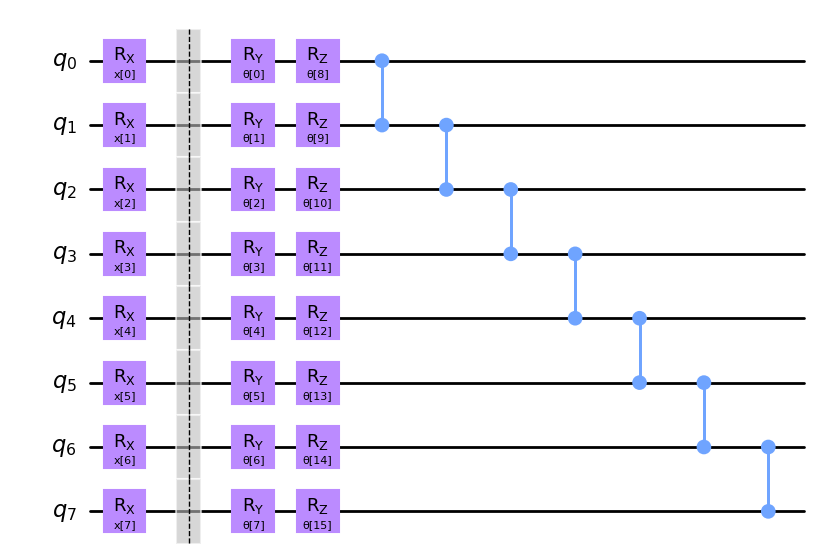

In [10]:
temp_qc = feature_map.copy()
temp_qc.barrier()
temp_qc.compose(ansatz, inplace=True)
temp_qc.draw('mpl')

In [11]:
class Net(torch.nn.Module):
    """Feedfoward neural network with 1 hidden layer"""

    def __init__(self, qnn, **kwargs):
        super().__init__()
        self.qnn = TorchConnector(qnn, **kwargs)
        self.loss_func = torch.nn.BCELoss()

    def forward(self, x):
        # Rescale output to lie between 0 and 1 instead of −1 and 1
        return torch.clamp((self.qnn(x) + 1) / 2, min=0.0, max=1.0)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = self.loss_func(out, labels.view(-1, 1))  # Calculate loss
        return loss

## Phase I

In [12]:
num_weights = len(weight_params)

# We use qiskit-qulacs to run qiskit circuits on qulacs backend
# This speeds up the training process

estimator = QulacsEstimator()
gradient = QulacsEstimatorGradient(estimator)

# One can use the Qiskit's primitives by uncommenting the lines below

# estimator = Estimator()
# gradient = ReverseEstimatorGradient(estimator)

n_qubits = ansatz.num_qubits
main_qc = QuantumCircuit(n_qubits)

assert feature_map.num_qubits == ansatz.num_qubits
main_qc.compose(feature_map, range(n_qubits), inplace=True)

residual_qc = main_qc.copy()  # used in Phase II

layer_params = []  # stores the parameters of layers
layer_param_values = []  # stores the corresponding parameter values

losses = []

s = time()

for layer_id in range(n_layer_steps):
    print("\nLayer:", layer_id)

    qc = QuantumCircuit(n_qubits)
    temp_params = []

    # Append layers
    for i in range(n_layers_to_add):
        params = ParameterVector(f"θ_{layer_id}_{i}", num_weights)
        qc.compose(
            ansatz.assign_parameters(dict(zip(weight_params, params))),
            range(n_qubits),
            inplace=True,
        )
        temp_params.append(params)

    # Parameter and its values for current layer
    # we perform a small deviation from all zeros
    temp_params = np.asarray(temp_params).flatten()
    temp_init = np.zeros(temp_params.shape) + 0.001

    main_qc.compose(qc, range(n_qubits), inplace=True)
    residual_qc.compose(qc, range(n_qubits), inplace=True)
    residual_qc.barrier()

    layer_params.append(temp_params)

    # Freeze all parameters before `n_layers_to_train`
    # To perform the freezing, we bind the parameter values
    # and keep only the trainable parameters for `n_layers_to_train` layers
    if layer_id >= n_layers_to_train:
        freeze_params = layer_params[-n_layers_to_train - 1]
        index = num_weights * n_layers_to_add * (n_layers_to_train - 1)
        freeze_param_values = layer_param_values[-index - num_weights *
                                                 n_layers_to_add:-index]
        main_qc = main_qc.bind_parameters(
            dict(zip(freeze_params, freeze_param_values)))
        initial_point = np.concatenate(
            (layer_param_values[-index:], temp_init))
        initial_params = np.asarray(
            layer_params[-n_layers_to_train:]).flatten()
    else:
        initial_point = np.concatenate((layer_param_values, temp_init))
        initial_params = np.asarray(layer_params).flatten()

    qnn = EstimatorQNN(
        estimator=estimator,
        circuit=main_qc,
        input_params=input_params,
        weight_params=initial_params,
        gradient=gradient,
        input_gradients=False,
    )

    # Model and Training
    model = Net(qnn, initial_weights=initial_point)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    epochs = 20  # Set number of epochs
    loss_list = []  # Store loss history
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        total_loss = []
        for batch in train_dataloader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss.append(loss.item())  # Store loss
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(
            100.0 * (epoch + 1) / epochs, loss_list[-1]))

    losses.append(loss_list)

    # Extract the current weights and store them
    with torch.no_grad():
        weights = [param for param in model.parameters()][0].numpy()

    if layer_id >= n_layers_to_train:
        layer_param_values = np.concatenate((layer_param_values, temp_init))
        index = num_weights * n_layers_to_add * n_layers_to_train
        layer_param_values[-index:] = weights.copy()
    else:
        layer_param_values = weights.copy()

e = time()
print("\nDuration {:.4f} s".format(e - s))


Layer: 0
Training [5%]	Loss: 0.7069
Training [10%]	Loss: 0.6924
Training [15%]	Loss: 0.6742
Training [20%]	Loss: 0.6497
Training [25%]	Loss: 0.6265
Training [30%]	Loss: 0.6072
Training [35%]	Loss: 0.5916
Training [40%]	Loss: 0.5644
Training [45%]	Loss: 0.5293
Training [50%]	Loss: 0.4779
Training [55%]	Loss: 0.4446
Training [60%]	Loss: 0.4232
Training [65%]	Loss: 0.4097
Training [70%]	Loss: 0.4077
Training [75%]	Loss: 0.3970
Training [80%]	Loss: 0.3960
Training [85%]	Loss: 0.3990
Training [90%]	Loss: 0.3921
Training [95%]	Loss: 0.3931
Training [100%]	Loss: 0.3859

Layer: 1
Training [5%]	Loss: 0.3898
Training [10%]	Loss: 0.3741
Training [15%]	Loss: 0.3498
Training [20%]	Loss: 0.3380
Training [25%]	Loss: 0.3286
Training [30%]	Loss: 0.3265
Training [35%]	Loss: 0.3250
Training [40%]	Loss: 0.3252
Training [45%]	Loss: 0.3215
Training [50%]	Loss: 0.3238
Training [55%]	Loss: 0.3280
Training [60%]	Loss: 0.3182
Training [65%]	Loss: 0.3201
Training [70%]	Loss: 0.3246
Training [75%]	Loss: 0.3203
T

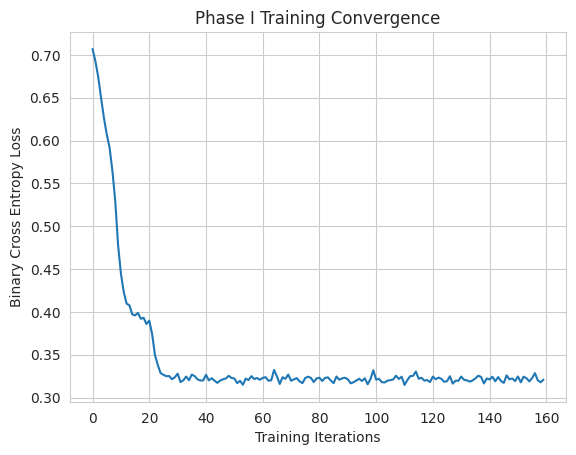

In [13]:
# Plot loss convergence
plt.plot(np.array(losses).flatten())
plt.title("Phase I Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Binary Cross Entropy Loss")
plt.show()

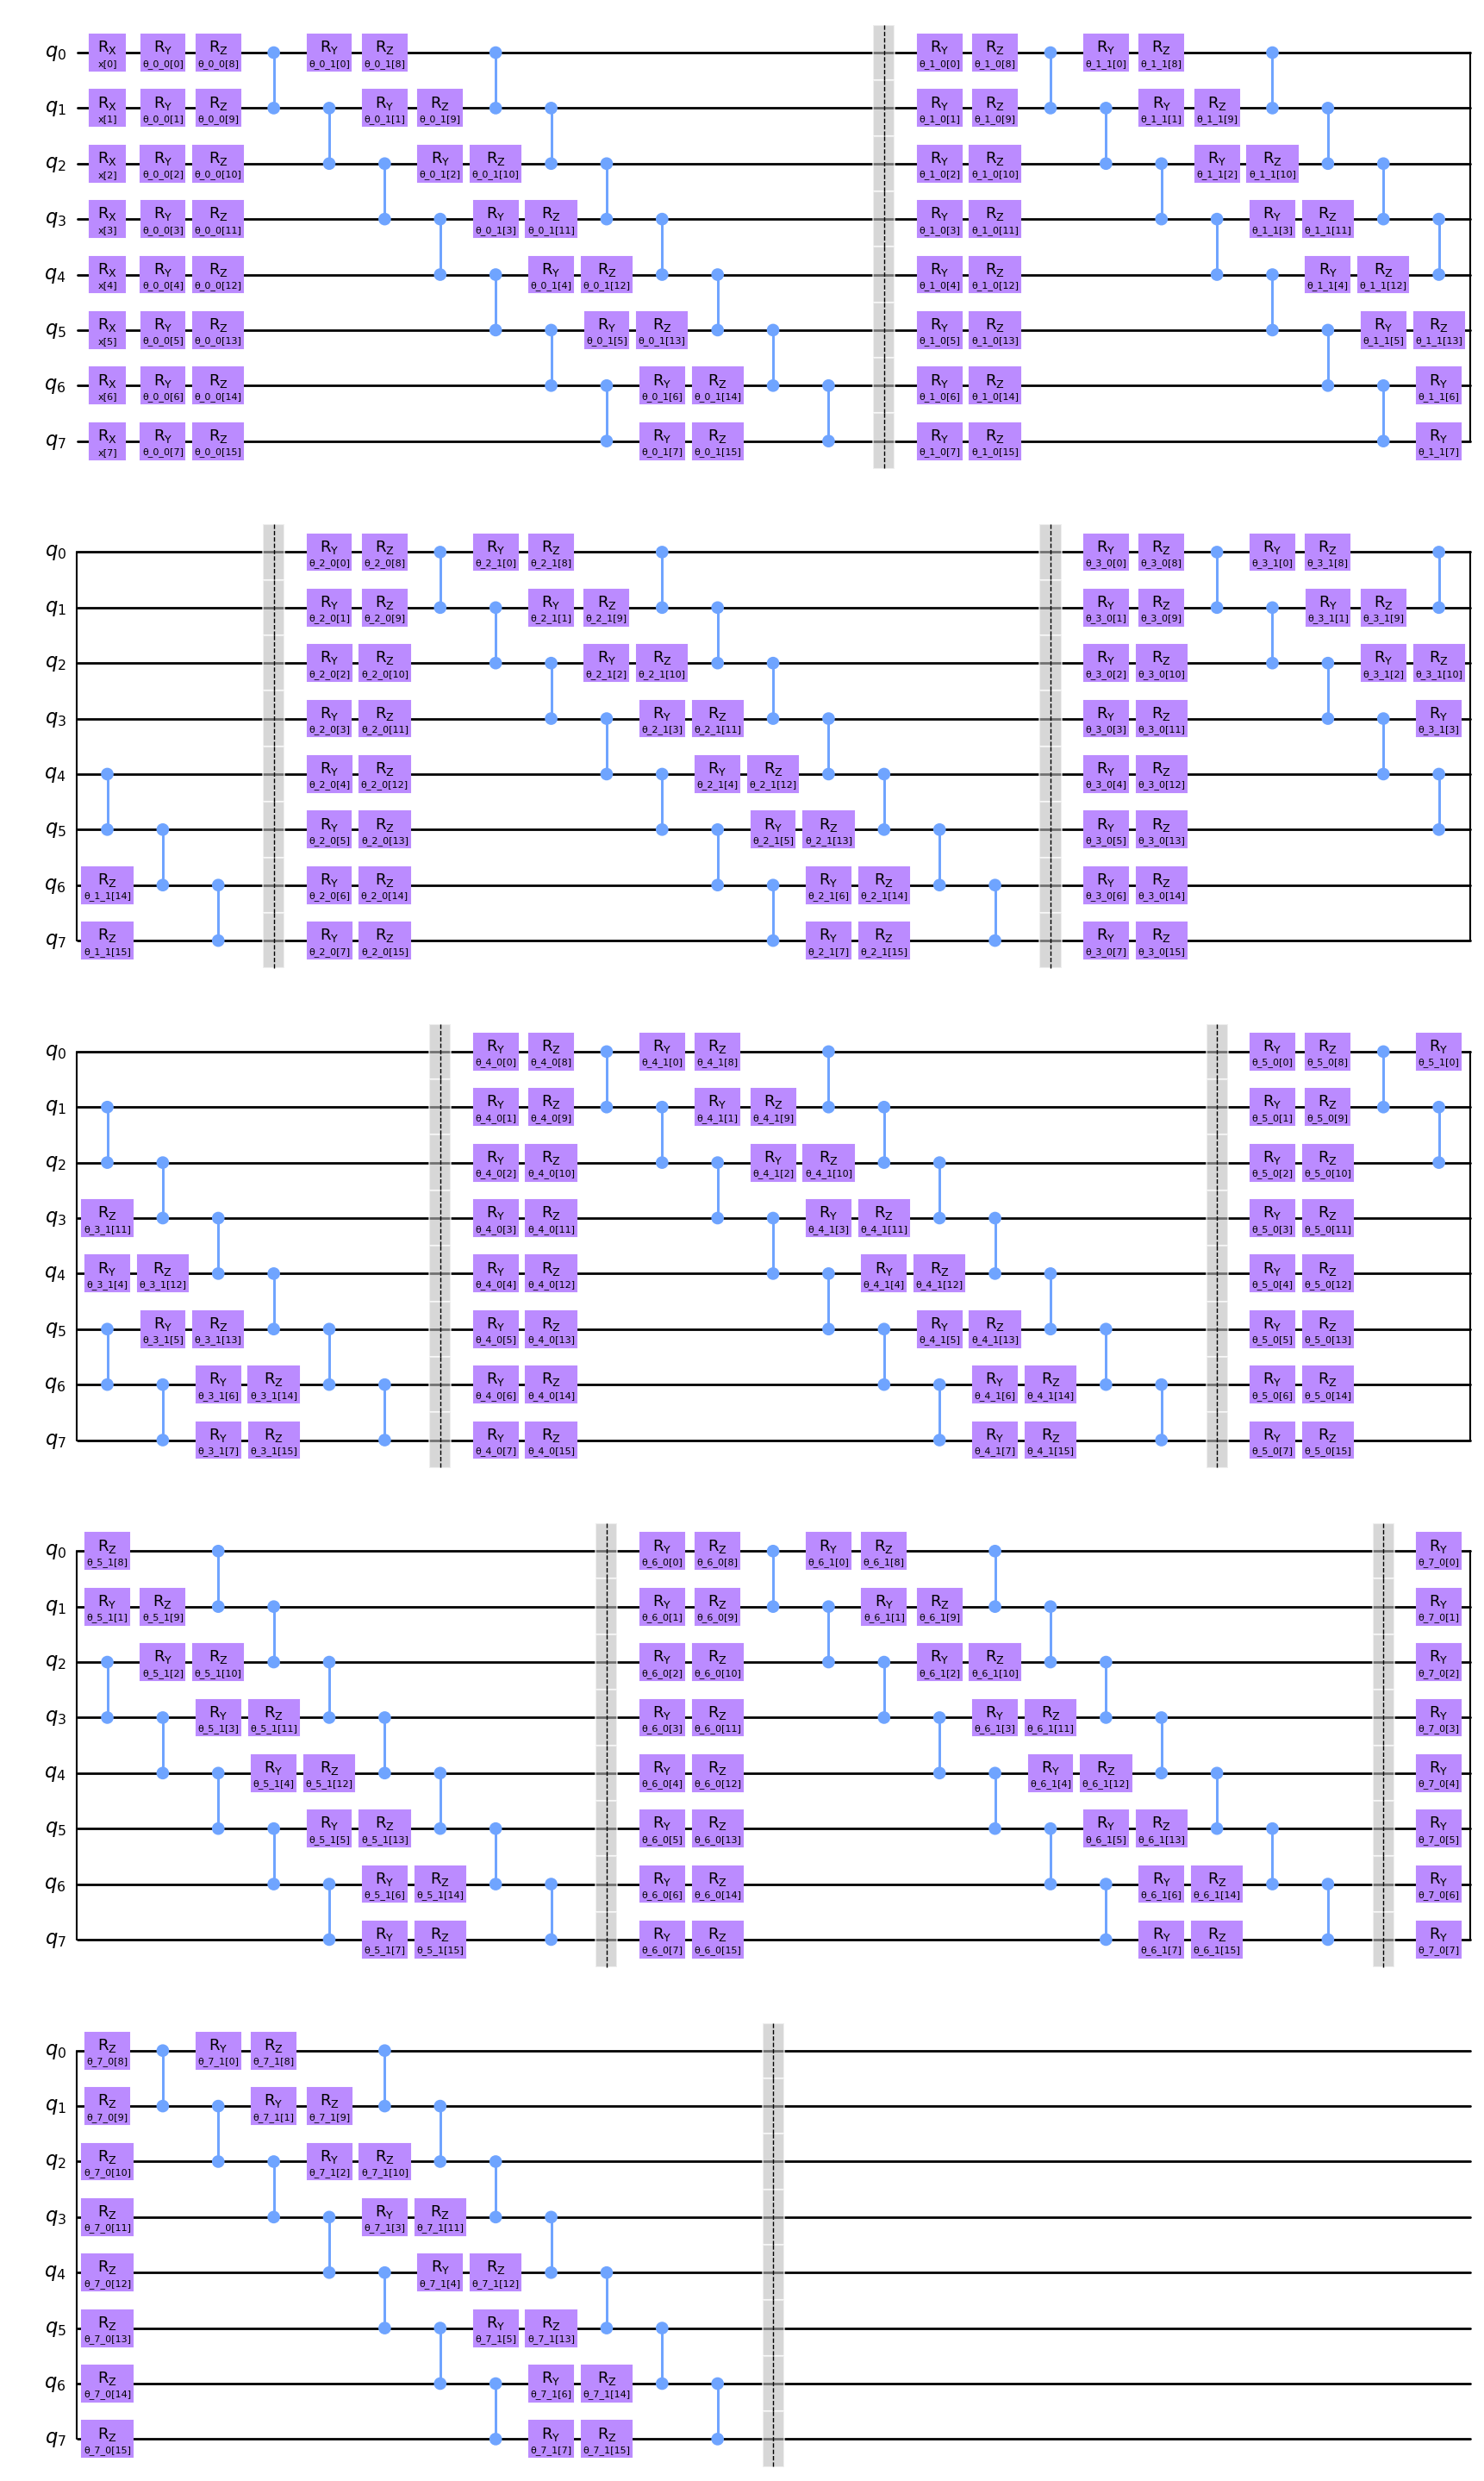

In [14]:
residual_qc.draw('mpl')

## Phase II

In [15]:
qc = residual_qc.copy()

# Number of weights in the first partition
n_p1_weights = int(len(layer_param_values) * partition_percentage)

# Partition 1 weights
p1_weights = dict(
    zip(
        np.asarray(layer_params).flatten()[:n_p1_weights],
        layer_param_values[:n_p1_weights],
    ))

# Partition 2 weights
p2_weights = dict(
    zip(
        np.asarray(layer_params).flatten()[n_p1_weights:],
        layer_param_values[n_p1_weights:],
    ))

losses2 = []

s = time()

print("\nSweep over partitions\n")
for sweep in range(n_sweeps):
    # configure and train first partition
    print("\nSweep {}, partition 1\n".format(sweep))

    # Freeze the partition 2 weights
    train_qc = qc.bind_parameters(p2_weights)

    # Train only partition 1 weights
    qnn = EstimatorQNN(
        estimator=estimator,
        circuit=train_qc,
        input_params=input_params,
        weight_params=list(p1_weights.keys()),
        gradient=gradient,
        input_gradients=True,
    )

    model = Net(qnn, initial_weights=list(p1_weights.values()))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    epochs = 20  # Set number of epochs
    loss_list = []  # Store loss history
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        total_loss = []
        for batch in train_dataloader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss.append(loss.item())  # Store loss
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(
            100.0 * (epoch + 1) / epochs, loss_list[-1]))

    losses.append(loss_list)

    with torch.no_grad():
        trained_weights = [param for param in model.parameters()][0].numpy()

    p1_weights = {
        key: value
        for key, value in zip(p1_weights.keys(), trained_weights)
    }

    # configure and train second partition
    print("\nSweep {}, partition 2\n".format(sweep))

    # Freeze the partition 1 weights
    train_qc = qc.bind_parameters(p1_weights)

    # Train only partition 2 weights
    qnn = EstimatorQNN(
        estimator=estimator,
        circuit=train_qc,
        input_params=input_params,
        weight_params=list(p2_weights.keys()),
        gradient=gradient,
        input_gradients=True,
    )

    model = Net(qnn, initial_weights=list(p2_weights.values()))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    epochs = 20  # Set number of epochs
    loss_list = []  # Store loss history
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        total_loss = []
        for batch in train_dataloader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss.append(loss.item())  # Store loss
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(
            100.0 * (epoch + 1) / epochs, loss_list[-1]))

    losses2.append(loss_list)

    with torch.no_grad():
        trained_weights = [param for param in model.parameters()][0].numpy()

    p2_weights = {
        key: value
        for key, value in zip(p2_weights.keys(), trained_weights)
    }

e = time()

print("\nDuration {:.4f} s".format(e - s))


Sweep over partitions


Sweep 0, partition 1

Training [5%]	Loss: 0.3233
Training [10%]	Loss: 0.3206
Training [15%]	Loss: 0.3256
Training [20%]	Loss: 0.3249
Training [25%]	Loss: 0.3195
Training [30%]	Loss: 0.3201
Training [35%]	Loss: 0.3165
Training [40%]	Loss: 0.3210
Training [45%]	Loss: 0.3186
Training [50%]	Loss: 0.3226
Training [55%]	Loss: 0.3152
Training [60%]	Loss: 0.3158
Training [65%]	Loss: 0.3229
Training [70%]	Loss: 0.3157
Training [75%]	Loss: 0.3189
Training [80%]	Loss: 0.3222
Training [85%]	Loss: 0.3203
Training [90%]	Loss: 0.3163
Training [95%]	Loss: 0.3175
Training [100%]	Loss: 0.3182

Sweep 0, partition 2

Training [5%]	Loss: 0.3169
Training [10%]	Loss: 0.3140
Training [15%]	Loss: 0.3172
Training [20%]	Loss: 0.3126
Training [25%]	Loss: 0.3144
Training [30%]	Loss: 0.3191
Training [35%]	Loss: 0.3164
Training [40%]	Loss: 0.3177
Training [45%]	Loss: 0.3144
Training [50%]	Loss: 0.3169
Training [55%]	Loss: 0.3125
Training [60%]	Loss: 0.3195
Training [65%]	Loss: 0.3164
Trainin

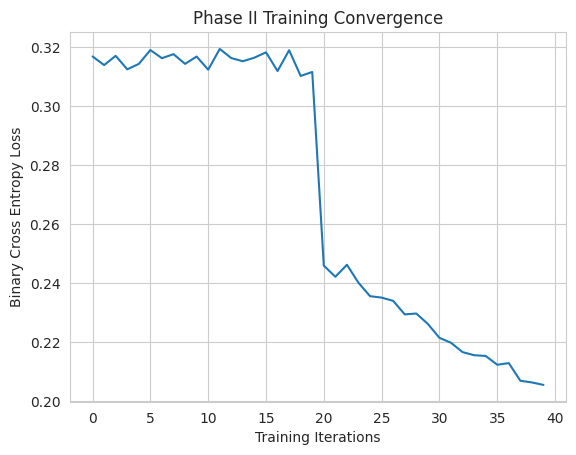

In [16]:
# Plot loss convergence
plt.plot(np.array(losses2).flatten())
plt.title("Phase II Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Binary Cross Entropy Loss")
plt.show()

Text(0.5, 1.0, 'Phase II Training Convergence')

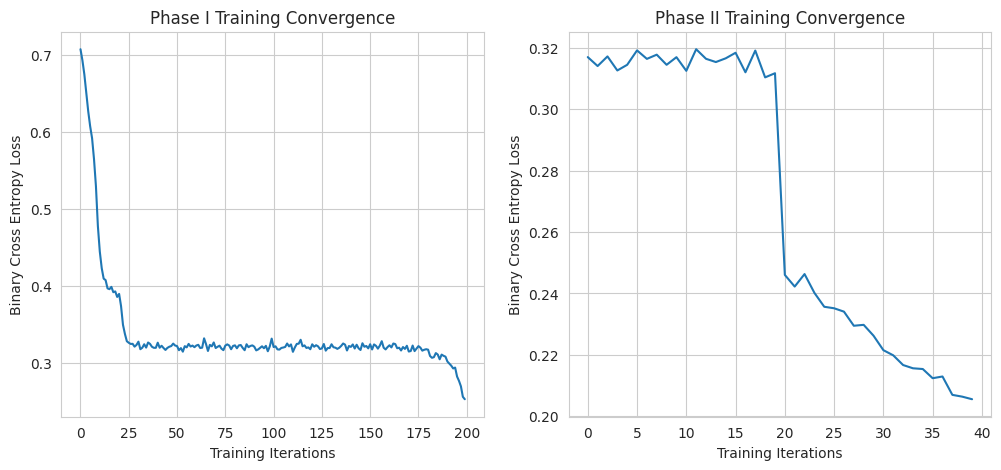

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(np.array(losses).flatten())
ax[0].set_xlabel("Training Iterations")
ax[0].set_ylabel("Binary Cross Entropy Loss")
ax[0].set_title("Phase I Training Convergence")

ax[1].plot(np.array(losses2).flatten())
ax[1].set_xlabel("Training Iterations")
ax[1].set_ylabel("Binary Cross Entropy Loss")
ax[1].set_title("Phase II Training Convergence")

In [18]:
def accuracy(outputs, labels):
    preds = outputs > 0.5
    return torch.tensor(
        torch.sum(preds == labels.view(-1, 1)).item() / len(preds))


def evaluate(model, loader):
    batch_accs = [accuracy(model(images), labels) for images, labels in loader]
    return torch.stack(batch_accs).mean().item()

In [19]:
predictions = []
targets = []

model.eval()
train_acc = evaluate(model, train_dataloader)
test_acc = evaluate(model, test_dataloader)

train_acc, test_acc

(0.9711538553237915, 0.9529569745063782)

In [20]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright